<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Estimating Baseline Performance

### What is a baseline model? 

Producing a baseline model is crucial for evaluating your model's performance on any machine learning problem. A baseline model is a basic solution that serves as a point of reference for comparing other models to. The baseline model's performance gives us an indication of how much better our models can perform relative to a naive approach. 

Let's say we are building a sentence similarity model where our training set contains pairs of sentences and we want to predict how similiar these sentences are on a scale from 1-5. We could spend months producing a complex machine learning solution to this problem and ultimately get a mean squared error (MSE) of 0.3. But is this result good or bad? There is no way of knowing without comparing it with some baseline performance. For our baseline model, we could predict the mean sentence similarity of sentence pairs in our training set (called the _zero rule_) and get a MSE of 0.35. So our model is worse than the baseline which indicates that we may want to consider using different features, models, evaluation metrics, etc. It is crucial that the choice of baseline model be tailored to a data science problem based on buisness goals and the specific modeling task.

### What are good baselines for sentence similarity?

For sentence similarity problems, we have two sub-tasks: 1) First, we need to produce a vector representation of each sentence in the sentence pair, known as an **embedding**. 2) Second, we need to compute the similarity between these two sentence embeddings.

For producing representations of sentences, there are some common baseline approaches: 
1. Create word embeddings for each word in a sentence
    1. word2vec word embeddings
    2. GLoVe word embeddings
    3. fastText word embeddings
    
2. Create sentence embeddings
    1. doc2vec document embeddings
    2. TF-IDF embeddings 

Then we have to compare our embeddings to calculate sentence similarity:
1. Word Embedding comparison
    1. Cosine Similarity (first requires averaging the word embeddings of all words in each sentence)
    2. Word Mover's Distance

2. Sentence Embedding comparison
    1. Cosine Similarity  
    
The different embedding models and similarity metrics are introduced below.

# Table of Contents
* [Data Loading and Preprocessing](#Data-Loading-and-Preprocessing)
    * [Load STS Benchmark Dataset](#Load-STS-Benchmark-Dataset)
    - [Preprocess / Tokenize](#Data-Preprocessing-/-Tokenization)
    - [Document Frequency Calculation](#Document-Frequency-Calculation)
* [Baseline Models](#Baseline-Models)
    - [Baseline #1: word2vec and cosine similarity](#Baseline-#1:-Word2vec-Embeddings-with-Cosine-Similarity)
    - [Baseline #2: word2vec and Word Mover's Distance](#Baseline-#2:-Word2vec-Embeddings-with-Word-Mover's-Distance)
    - [Baseline #3: GloVe and cosine similarity](#Baseline-#3:-GloVe-Embeddings-with-Cosine-Similarity)
    * [Baseline #4: GloVe and Word Mover's Distance](#Baseline-#4:-GloVe-Embeddings-with-Word-Mover's-Distance)
    - [Baseline #5: fastText and cosine similarity](#Baseline-#5:-fastText-Embeddings-with-Cosine-Similarity)
    - [Baseline #6: fastText and Word Mover's Distance](#Baseline-#6:-fastText-Embeddings-with-Word-Mover's-Distance)

    * [Baseline #7: TF-IDF and cosine similarity](#Baseline-#7:-TF-IDF-Embeddings-with-Cosine-Similarity)
    * [Baseline #8: Doc2vec and cosine similarity](#Baseline-#8:-Doc2vec-Embeddings-with-Cosine-Similarity))

* [Comparison of Baseline Models](#Comparison-of-Baseline-Models)

# Reference running time 
The table below provide some reference running time of each section on CPU and GPU machines.  

|Notebook Section|4 **CPU**s, 14GB memory VM| 1 NVIDIA Tesla K80 GPU, 12GB GPU memory VM|
|:---------------|:------------------------:|:------------------------------------------:|
|Whole notebook| ~ 35 mintues| ~ 28 minutes|
|Data Loading and Preprocessing| ~ 8 minutes| ~ 6 minutes|
|Baseline #1| ~ 4 minutes| ~ 3 minutes|
|Baseline #2| ~ 5 seconds| ~ 3 seconds|
|Baseline #3| ~ 18 minutes| ~ 14 minutes|
|Baseline #4| ~ 5 seconds| ~ 5 seconds|
|Baseline #5| Memory error, please skip if error occurs| ~ 3 minutes|
|Baseline #6| Memory error, please skip if error occurs| ~ 5 seconds|
|Baseline #7| ~ 6 seconds| ~ 5 seconds|
|Baseline #8| ~ 3 minutes| ~ 2 minutes|
|Comparison of Baseline Models| ~ 1 second| ~ 2 seconds|


In [6]:
#Import Packages
import sys
# Set the environment path
sys.path.append("../../")  
import os
from collections import Counter
import math
import numpy as np
from tempfile import TemporaryDirectory
import scrapbook as sb
import scipy
from scipy.spatial import distance
import gensim
from gensim.models.doc2vec import LabeledSentence
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
%matplotlib inline

#Import utility functions
from utils_nlp.dataset.preprocess import to_lowercase, to_spacy_tokens
from utils_nlp.dataset import stsbenchmark
from utils_nlp.dataset.preprocess import (
    to_lowercase,
    to_spacy_tokens,
    rm_spacy_stopwords,
)
from utils_nlp.models.pretrained_embeddings import word2vec
from utils_nlp.models.pretrained_embeddings import glove
from utils_nlp.models.pretrained_embeddings import fasttext

print("System version: {}".format(sys.version))
print("Gensim version: {}".format(gensim.__version__))

System version: 3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
Gensim version: 3.7.3


In [7]:
# Set the path where you datasets are located
tmp_dir = TemporaryDirectory()
BASE_DATA_PATH = tmp_dir.name 

# Data Loading and Preprocessing

### Load STS Benchmark Dataset

Here we utilize the [STS Benchmark dataset](http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark#STS_benchmark_dataset_and_companion_dataset) which contains a selection of English datasets that were used in Semantic Textual Similarity (STS) tasks 2012-2017. The datasets include text from image captions, news headlines, and user forums. The dataset contains 8,628 sentence pairs with a human-labeled integer representing the sentences' similarity (ranging from 0, for no meaning overlap, to 5, meaning equivalence).

In [8]:
# Produce a pandas dataframe for the training and test sets
train_raw = stsbenchmark.load_pandas_df(BASE_DATA_PATH, file_split="train")
test_raw = stsbenchmark.load_pandas_df(BASE_DATA_PATH, file_split="test")

# Clean the sts dataset
sts_train = stsbenchmark.clean_sts(train_raw)
sts_test = stsbenchmark.clean_sts(test_raw)

100%|██████████████████████████████████████████████████████████████████████████████████| 401/401 [00:01<00:00, 247KB/s]


Data downloaded to C:\Users\cocochra\AppData\Local\Temp\tmpp2a0cw_t\raw\stsbenchmark


100%|██████████████████████████████████████████████████████████████████████████████████| 401/401 [00:01<00:00, 243KB/s]


Data downloaded to C:\Users\cocochra\AppData\Local\Temp\tmpp2a0cw_t\raw\stsbenchmark


In [9]:
print("Training set has {} sentences".format(len(sts_train)))
print("Testing set has {} sentences".format(len(sts_test)))

Training set has 5749 sentences
Testing set has 1379 sentences


In [10]:
sts_test.head(10)

,score,sentence1,sentence2
0,2.500,A girl is styling her hair.,A girl is brushing her hair.
1,3.600,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.
2,5.000,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.
3,4.200,A man is cutting up a cucumber.,A man is slicing a cucumber.
4,1.500,A man is playing a harp.,A man is playing a keyboard.
5,1.800,A woman is cutting onions.,A woman is cutting tofu.
6,3.500,A man is riding an electric bicycle.,A man is riding a bicycle.
7,2.200,A man is playing the drums.,A man is playing the guitar.
8,2.200,A man is playing guitar.,A lady is playing the guitar.
9,1.714,A man is playing a guitar.,A man is playing a trumpet.


### Data Preprocessing / Tokenization

Our baseline models will expect that each sentence is represented by a list of **tokens**. Tokens are linguistic units like words, punctuation marks, numbers, etc. We'll use our util functions which utilize the spaCy package, a popular package for performing tokenization.

It's also common to remove high-frequency words which do not help distinguish one sentence from another, so called **stop words**. For example, "the", "and", "a", etc. are typical stop words although each tokenization package may differ in the words they consider to be stop words. We'll tokenize our corpus with and without stop words so that we can compare our methods with and without stop words.

#### Training Set Preprocessing

In [11]:
# Convert all text to lowercase
df_low = to_lowercase(sts_train)  
# Tokenize text
sts_tokenize = to_spacy_tokens(df_low) 
# Tokenize with removal of stopwords
sts_train_stop = rm_spacy_stopwords(sts_tokenize) 

Now each row in our dataframe contains:  
- The similarity score of the sentence pair
- The 2 original sentences from our datasets  
- A column for each sentence's tokenization with stop words  
- A column for each sentence's tokenization without stop words

In [12]:
sts_train_stop.head(5)

,score,sentence1,sentence2,sentence1_tokens,sentence2_tokens,sentence1_tokens_rm_stopwords,sentence2_tokens_rm_stopwords
0,5.00,a plane is taking off.,an air plane is taking off.,"[a, plane, is, taking, off, .]","[an, air, plane, is, taking, off, .]","[plane, taking, .]","[air, plane, taking, .]"
1,3.80,a man is playing a large flute.,a man is playing a flute.,"[a, man, is, playing, a, large, flute, .]","[a, man, is, playing, a, flute, .]","[man, playing, large, flute, .]","[man, playing, flute, .]"
2,3.80,a man is spreading shreded cheese on a pizza.,a man is spreading shredded cheese on an uncoo...,"[a, man, is, spreading, shreded, cheese, on, a...","[a, man, is, spreading, shredded, cheese, on, ...","[man, spreading, shreded, cheese, pizza, .]","[man, spreading, shredded, cheese, uncooked, p..."
3,2.60,three men are playing chess.,two men are playing chess.,"[three, men, are, playing, chess, .]","[two, men, are, playing, chess, .]","[men, playing, chess, .]","[men, playing, chess, .]"
4,4.25,a man is playing the cello.,a man seated is playing the cello.,"[a, man, is, playing, the, cello, .]","[a, man, seated, is, playing, the, cello, .]","[man, playing, cello, .]","[man, seated, playing, cello, .]"


#### Test Set Preprocessing

In [13]:
# Convert all text to lowercase
df_low = to_lowercase(sts_test)
# Tokenize text
sts_tokenize = to_spacy_tokens(df_low)
# Tokenize with removal of stopwords
sts_test_stop = rm_spacy_stopwords(sts_tokenize)

### Document Frequency Calculation

Many baseline models we explore will require calculation of how frequently a word appears in our corpus. To calculate this, we iterate through the sentences in our training set and count the number of sentences that contain each word. There are other ways to produce this calculation, including pulling larger datasets from the web (like Wikipedia data) and calculating the frequencies on that data. Note that "document" refers to some larger chunk of multiple tokens/words. In our case, our documents will actually be individual sentences. 

In [14]:
def get_document_frequency(df):
    """Iterate through all sentences in dataframe and create a dictionary 
    mapping tokens to the number of sentences in our corpus they appear in
    
    Args:
        df (pandas dataframe): dataframe of sentence pairs with their similarity scores
        
    Returns:
        document_frequency_dict (dictionary): mapping from tokens to number of sentences they appear in
        n (int): number of sentences in the corpus
    """
    document_frequency_dict = {}
    all_sentences =  df[["sentence1_tokens", "sentence2_tokens"]]
    sentences = all_sentences.values.flatten().tolist()
    n = len(sentences)

    for s in sentences:
        for token in set(s):
            document_frequency_dict[token] = document_frequency_dict.get(token, 0) + 1

    return document_frequency_dict, n

In [15]:
# Note that we need to calculate these values on our training set so that we don't "peek at" our test set until test time
document_frequencies, num_documents = get_document_frequency(sts_train_stop)

In [16]:
num_documents

11498

# Baseline Models

As we consider each of the baseline models, we'll save all model predictions in a dictionary and will evaluate the results at the end of this notebook.

In [17]:
baselines = {}

## Baseline #1: Word2vec Embeddings with Cosine Similarity

This baseline first constructs word embeddings using word2vec. Once we have a word embedding (vector) for each word in the sentence, we calculate an embedding for the full sentence by taking the (weighted) average of all the word embeddings. The weights will be calculated using TF-IDF. Lastly, in order to compare the two sentence embeddings we use the cosine similarity metric. 

### What is Word2Vec?
Word2vec is a predictive model for learning word embeddings from text (see [original research paper](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)). Word embeddings are learned such that words that share common contexts in the corpus will be close together in the vector space. There are two different model architectures that can be used to produce word2vec embeddings: continuous bag-of-words (CBOW) or continuous skip-gram. The former uses a window of surrounding words (the "context") to predict the current word and the latter uses the current word to predict the surrounding context words. See this [tutorial](https://www.guru99.com/word-embedding-word2vec.html#3) on word2vec for more detailed information about the model.

For our purposes, we use pretrained word2vec word embeddings. These embeddings were trained on a Google News corpus and provide 300-dimensional embeddings (vectors) for 3 million English words. See this [link](https://code.google.com/archive/p/word2vec/) for the original location of the embeddings and see the code below to load these word embeddings.

In [18]:
word2vec_model = word2vec.load_pretrained_vectors(dir_path=BASE_DATA_PATH)

100%|████████████████████████████████████████████████████████████████████████████| 1.61M/1.61M [01:08<00:00, 23.4kKB/s]
C:\Users\cocochra\AppData\Local\Continuum\anaconda3\envs\nlp_gpu\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### What is TF-IDF?

TF-IDF or term frequency-inverse document frequency is a weighting scheme intended to measure how important a word is to the document (or sentence in our case) within the broader corpus (our dataset). The weight "increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus" ([tutorial link](http://www.tfidf.com/)). When we're averaging together many different word vectors to get a sentence embedding, it makes sense to give stronger weights to words that are more distinct relative to the corpus and that have a high frequency in the sentence. The TF-IDF weights capture this intution, with the weight increasing as term frequency increases and/or as the inverse document frequency increases.

For a term $t$ in sentence $s$ in corpus $c$, then the TF-IDF weight is 
$$w_{t,s} = TF_{t,s} * \log{\frac{N}{df_t}}$$
where:  
$TF_{t,s}$ = the number of times term $t$ appears in sentence $s$  
$df_t$ = the number of sentences containing term $t$  
$N$ = the size of the corpus.  

In these baselines, we calculate the TF-IDF weighted average of all the word embeddings. The code below implements this weighted average given a list of tokens and an embedding model.

In [19]:
def average_sentence_embedding(tokens, embedding_model):
    """Calculate TF-IDF weighted average embedding for a sentence
    
    Args:
        tokens (list): list of tokens in a sentence
        embedding_model: model to use for word embedding (word2vec, glove, fastText, etc.)
    
    Returns:
        list: vector representing the sentence
    """
    # Throw away tokens that are not in the embedding model
    tokens = [i for i in tokens if i in embedding_model]

    if len(tokens) == 0:
        return []

    # We will weight by TF-IDF. The TF part is calculated by:
    # (# of times term appears / total terms in sentence)
    count = Counter(tokens)
    token_list = list(count)
    term_frequency = [count[i] / len(tokens) for i in token_list]

    # Now for the IDF part: LOG(# documents / # documents with term in it)
    inv_doc_frequency = [
        math.log(num_documents / (document_frequencies.get(i, 0) + 1)) for i in count
    ]

    # Put the TF-IDF together and produce the weighted average of vector embeddings
    word_embeddings = [embedding_model[token] for token in token_list]
    weights = [term_frequency[i] * inv_doc_frequency[i] for i in range(len(token_list))]
    return list(np.average(word_embeddings, weights=weights, axis=0))

### What is Cosine Similarity?

Cosine similarity is a common similarity metric between vectors. Intuitively it measures the cosine of the angle between any two vectors. With vectors $a$ and $b$, the cosine similarity is: cosine similarity($a$,$b$) = $\frac{\vec{a} \cdot \vec{b} }{||\vec{a}|| ||\vec{b}||}$


In [20]:
def calculate_cosine_similarity(embedding1, embedding2):
    """Calculate cosine similarity between two embedding vectors
    
    Args:
        embedding1 (list): embedding for the first sentence
        embedding2 (list): embedding for the second sentence
    
    Returns:
        list: cosine similarity value between the two embeddings
    """
    # distance.cosine calculates cosine DISTANCE, so we need to
    # return 1 - distance to get cosine similarity
    cosine_similarity = 1 - distance.cosine(embedding1, embedding2)
    return cosine_similarity

### Get Sentence Similarity Predictions for Test Set

Now, we calculate predictions for each sentence pair found in the test set.

In [21]:
def average_word_embedding_cosine_similarity(df, embedding_model, rm_stopwords=False):
    """Calculate the cosine similarity between TF-IDF weighted averaged embeddings
    
    Args:
        df (pandas dataframe): dataframe as provided by the nlp_utils
        embedding_model: word embedding model
        rm_stopwords (bool): whether to remove stop words (True) or not (False)
    
    Returns:
        list: predicted values for sentence similarity of test set examples
    """
    if rm_stopwords:
        df['sentence1_embedding'] = df.apply(lambda x: average_sentence_embedding(x.sentence1_tokens_rm_stopwords, embedding_model), axis=1)
        df['sentence2_embedding'] = df.apply(lambda x: average_sentence_embedding(x.sentence2_tokens_rm_stopwords, embedding_model), axis=1)
    else:
        df['sentence1_embedding'] = df.apply(lambda x: average_sentence_embedding(x.sentence1_tokens, embedding_model), axis=1)
        df['sentence2_embedding'] = df.apply(lambda x: average_sentence_embedding(x.sentence2_tokens, embedding_model), axis=1)

    df['predictions'] = df.apply(lambda x: calculate_cosine_similarity(x.sentence1_embedding, x.sentence2_embedding) if 
                                 (sum(x.sentence1_embedding) != 0 and sum(x.sentence2_embedding) != 0) else 0, axis=1)
    
    return df['predictions'].tolist()

In [22]:
# Get predictions using average word2vec embeddings both with and without stop words
baselines["Word2vec Cosine"] = average_word_embedding_cosine_similarity(
    sts_test_stop, word2vec_model, rm_stopwords=True
)
baselines["Word2vec Cosine with Stop Words"] = average_word_embedding_cosine_similarity(
    sts_test_stop, word2vec_model, rm_stopwords=False
)

## Baseline #2: Word2vec Embeddings with Word Mover's Distance 

This baseline first constructs word embeddings using word2vec (for an introduction to word2vec, see [Background on Word2Vec](#What-is-Word2Vec?)). Then all the word embeddings are used to calculate sentence similarity using the word mover's distance.  

### What is Word Mover's Distance (WMD)?
Word Mover's Distance (WMD) is a metric that "adapts the earth mover’s distance to the space of documents: the distance between two texts is given by the total amount of “mass” needed to move the words from one side into the other, multiplied by the distance the words need to move." We'll utilize word2vec's implementation of word mover's distance. See this [blog](http://vene.ro/blog/word-movers-distance-in-python.html) for additional information about this similarity measure.

### Get Sentence Similarity Predictions for Test Set

Now, we calculate predictions for each of sentence pairs found in the test set.

In [23]:
def word_embedding_WMD(df, embedding_model, rm_stopwords=False):
    """Calculate Word Mover's Distance between two sentences using embeddings
    
    Args:
        df (pandas dataframe): dataframe as provided by the nlp_utils
        embedding_model (gensim model): word embedding model
        rm_stopwords (bool): whether to remove stop words (True) or not (False)
    
    Returns:
        list: predicted values for sentence similarity of test set examples
    """
    if rm_stopwords:
        df['sentence1_cleaned'] = df.apply(lambda x: [i for i in x.sentence1_tokens_rm_stopwords if i in embedding_model], axis=1)
        df['sentence2_cleaned'] = df.apply(lambda x: [i for i in x.sentence2_tokens_rm_stopwords if i in embedding_model], axis=1)
    else:
        df['sentence1_cleaned'] = df.apply(lambda x: [i for i in x.sentence1_tokens if i in embedding_model], axis=1)
        df['sentence2_cleaned'] = df.apply(lambda x: [i for i in x.sentence2_tokens if i in embedding_model], axis=1)

    # wmdistance takes the raw tokens and performs the word2vec embedding itself
    df['predictions'] = df.apply(lambda x: -embedding_model.wmdistance(x.sentence1_cleaned, x.sentence2_cleaned) if 
                                 (len(x.sentence1_cleaned) != 0 and len(x.sentence2_cleaned) != 0) else 0, axis=1)
    
    return df['predictions'].tolist()

In [24]:
# Get predictions using word2vec embeddings and WMD both with and without stop words
baselines["Word2vec WMD"] = word_embedding_WMD(sts_test_stop, word2vec_model, rm_stopwords=True)
baselines["Word2vec WMD with Stop Words"] = word_embedding_WMD(
    sts_test_stop, word2vec_model, rm_stopwords=False
)

## Baseline #3: GloVe Embeddings with Cosine Similarity

This baseline first constructs word embeddings using GloVE. Once we have a word embedding (vector) for each word in the sentence, we calculate an embedding for the full sentence by taking the (weighted) average of all the word embeddings. The weights will be calculated using TF-IDF. Lastly, in order to compare the two sentence embeddings we use the cosine similarity metric (for an introduction to the cosine similarity metric, see [Background on Cosine Similarity](#What-is-Cosine-Similarity?)). 

### What is GloVe?
GloVe is an unsupervised algorithm for obtaining word embeddings created by the Stanford NLP group (see [original research paper](https://nlp.stanford.edu/pubs/glove.pdf)) Training occurs on word-word co-occurrence statistics with the objective of learning word embeddings such that the dot product of two words' embeddings is equal to the words' probability of co-occurrence. See this [tutorial](https://nlp.stanford.edu/projects/glove/) on GloVe for more detailed background on the model. For our purposes, we use pretrained GloVe word embeddings (glove.840B.300d.zip which can be found through the above link). These embeddings were trained on Common Crawl data and provide 300-dimensional embeddings (vectors) for 2.2 million English words. Below is the code to load in the GloVe embeddings.

In [25]:
glove_model = glove.load_pretrained_vectors(dir_path=BASE_DATA_PATH)

100%|████████████████████████████████████████████████████████████████████████████| 2.13M/2.13M [01:58<00:00, 17.9kKB/s]
C:\Users\cocochra\AppData\Local\Continuum\anaconda3\envs\nlp_gpu\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [26]:
# Get predictions using GloVe embeddings and cosine similarity both with and without stop words
baselines["GLoVe Cosine"] = average_word_embedding_cosine_similarity(
    sts_test_stop, glove_model, rm_stopwords=True
)
baselines["GLoVe Cosine with Stop Words"] = average_word_embedding_cosine_similarity(
    sts_test_stop, glove_model, rm_stopwords=False
)

## Baseline #4: GloVe Embeddings with Word Mover's Distance

This baseline first constructs word embeddings using GloVe (for an introduction on GloVe, see [Background on GloVe](#What-is-GloVe?)). Then all the word embeddings are used to calculate sentence similarity using the word mover's distance (for an introduction to WMD, see [Background on Word Mover's Distance](#What-is-Word-Mover's-Distance-(WMD)?)).  

In [27]:
# Get predictions using GloVe embeddings and WMD both with and without stop words
baselines["GLoVe WMD"] = word_embedding_WMD(sts_test_stop, glove_model, rm_stopwords=True)
baselines["GLoVe WMD with Stop Words"] = word_embedding_WMD(
    sts_test_stop, glove_model, rm_stopwords=False
)

## Baseline #5: fastText Embeddings with Cosine Similarity

This baseline first constructs word embeddings using fastText. Once we have a word embedding (vector) for each word in the sentence, we calculate an embedding for the full sentence by taking the (weighted) average of all the word embeddings. The weights will be calculated using TF-IDF. Lastly, in order to compare the two sentence embeddings we use the cosine similarity metric (for an introduction to the cosine similarity metric, see [Background on Cosine Similarity](#What-is-Cosine-Similarity?)). 

### What is fastText?

fastText is an unsupervised algorithm created by Facebook Research for efficiently learning word embeddings (see [original research paper](https://arxiv.org/pdf/1607.04606.pdf)). fastText is significantly different than word2vec or GloVe in that these two algorithms we saw earlier treat each word as the smallest possible unit to find an embedding for. Conversely, fastText assumes that words are formed by an n-gram of characters (i.e. 2-grams of the word "language" would be {la, an, ng, gu, ua, ag, ge}). The embedding for a word is then composed of the sum of these character n-grams. This has advantages when finding word embeddings for rare words and words not present in the dictionary, as these words can still be broken down into character n-grams. Typically, for smaller datasets, fastText performs better than word2vec or GloVe. See this [tutorial](https://fasttext.cc/docs/en/unsupervised-tutorial.html) on fastText for more detail. We will use the pretrained word embeddings for the English language (wiki.en.bin; these embeddings as well as embeddings for 156 other languages can be found [here](https://fasttext.cc/docs/en/english-vectors.html)). These are 300-dimensional embeddings (vectors) trained on Wikipedia data.

In [28]:
fastText_model = fasttext.load_pretrained_vectors(dest_path=BASE_DATA_PATH)

100%|████████████████████████████████████████████████████████████████████████████| 2.56M/2.56M [01:46<00:00, 24.0kKB/s]


In [29]:
# Get predictions using fastText embeddings and cosine similarity both with and without stop words
baselines["fastText Cosine"] = average_word_embedding_cosine_similarity(
    sts_test_stop, fastText_model, rm_stopwords=True
)
baselines["fastText Cosine with Stop Words"] = average_word_embedding_cosine_similarity(
    sts_test_stop, fastText_model, rm_stopwords=False
)

C:\Users\cocochra\AppData\Local\Continuum\anaconda3\envs\nlp_gpu\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if sys.path[0] == '':
C:\Users\cocochra\AppData\Local\Continuum\anaconda3\envs\nlp_gpu\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


## Baseline #6: fastText Embeddings with Word Mover's Distance

In [30]:
# Get predictions using fastText embeddings and WMD both with and without stop words
baselines["fastText WMD"] = word_embedding_WMD(sts_test_stop, fastText_model, rm_stopwords=True)
baselines["fastText WMD with Stop Words"] = word_embedding_WMD(
    sts_test_stop, fastText_model, rm_stopwords=False
)

C:\Users\cocochra\AppData\Local\Continuum\anaconda3\envs\nlp_gpu\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  del sys.path[0]
C:\Users\cocochra\AppData\Local\Continuum\anaconda3\envs\nlp_gpu\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\Users\cocochra\AppData\Local\Continuum\anaconda3\envs\nlp_gpu\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
C:\Users\cocochra\AppData\Local\Continuum\anaconda3\envs\nlp_gpu\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  app.launch_new_instance()
C:\Users\cocochra\A

## Baseline #7: TF-IDF Embeddings with Cosine Similarity

This baseline first constructs a document embedding based on bag-of-words with TF-IDF weighting (for an introduction to TF-IDF, see [Background on TF-IDF](#What-is-TF-IDF?). Then we apply cosine similarity between the two embeddings in the sentence pair (for an introduction to the cosine similarity metric, see [Background on Cosine Similarity](#What-is-Cosine-Similarity?)).

### Bag-of-Words

The most basic approach for document embeddings is called Bag-of-Words. This method first determines the vocabulary across the entire corpus and then, for each document, creates a vector containing the number of times each vocabulary word appeared in the given document. These vectors are obviously very sparse and typical bag-of-words implementations ignore terms whose document frequency is less than some threshold in order to reduce sparsity. We also often ignore stop words as they add little semantic information. 

In [33]:
def tfidf_cosine_similarity(df, rm_stopwords=False):
    """Calculate cosine similarity between TF-IDF document embeddings
    
    Args:
        df (pandas dataframe): dataframe as provided by the nlp_utils
        rm_stopwords (bool): whether to remove stop words (True) or not (False)
    
    Returns:
        list: predicted values for sentence similarity of test set examples
    """
    stop_word_param = "english" if rm_stopwords else None

    tf = TfidfVectorizer(
        input="content",
        analyzer="word",
        min_df=0,
        stop_words=stop_word_param,
        sublinear_tf=True,
    )
    all_sentences = df[["sentence1", "sentence2"]]
    corpus = np.concatenate([df["sentence1"].values, df["sentence2"].values])
    tfidf_matrix = np.array(tf.fit_transform(corpus).todense())
    num_samples = len(df.index)
    
    # calculate the cosine similarity between pairs of tfidf embeddings
    # first pair at index 0 and n in tfidf_matrix, second pair at 1 and n+1, etc.
    df["predictions"] = df.apply(
        lambda x: calculate_cosine_similarity(
            tfidf_matrix[int(x.name), :], tfidf_matrix[num_samples + int(x.name), :]
        )
        if (
            sum(tfidf_matrix[int(x.name), :]) != 0
            and sum(tfidf_matrix[num_samples + int(x.name), :]) != 0
        )
        else 0,
        axis=1,
    )
    return df["predictions"].tolist()

In [34]:
baselines["TF-IDF Cosine"] = tfidf_cosine_similarity(sts_test_stop, rm_stopwords=True)
baselines["TF-IDF Cosine with Stop Words"] = tfidf_cosine_similarity(
    sts_test_stop, rm_stopwords=False
)

## Baseline #8: Doc2vec Embeddings with Cosine Similarity

This baseline constructs document embeddings using doc2vec and then applies cosine similarity to measure each sentence pair's similarity (for an introduction to the cosine similarity metric, see [Background on Cosine Similarity](#What-is-Cosine-Similarity?)).

### What is Doc2Vec?

Doc2vec is an extension of word2vec which produces embeddings of a document. Note that "document" refers to some larger chunk of multiple tokens/words. In our case, our documents will actually be individual setntences. The algorithm not only exploits the idea of context words (like in word2vec), but also incorporates the context of the document. There are again two model architectures that parallel those of word2vec: Paragraph Vectors Distributed Memory (PV-DM) and Paragraph Vectors Distributed Bag-of-Words (PV-DBOW). PV-DM randomly samples consecutive words in a paragraph and predicts a center word by utilizing the context words and the paragraph id. PV-DBOW takes a paragraph id and uses it to predict words in the context. 

See [tutorial #1](https://kanoki.org/2019/03/07/sentence-similarity-in-python-using-doc2vec/) or [tutorial #2](https://gab41.lab41.org/doc2vec-to-assess-semantic-similarity-in-source-code-667acb3e62d7) for more information and an example of using Doc2vec for sentence similarity.

In [35]:
# Doc2vec requires unique ids for each sentence, so we'll iterate 
# through our dataframe, adding a new ID column

all_sentences =  sts_test_stop[["sentence1", "sentence2"]]
corpus = all_sentences.values.flatten().tolist()
# Produce dictionary of sentence to id
sentence_id = {sent: i for i, sent in enumerate(set(corpus))}

def assign_id(row):
    return sentence_id[row]

sts_test_stop["qid1"] = sts_test_stop["sentence1"].apply(assign_id)
sts_test_stop["qid2"] = sts_test_stop["sentence2"].apply(assign_id)

In [36]:
def doc2vec_cosine(df, rm_stopwords=False):
    """Calculate cosine similarity between each sentence pair using Doc2Vec embeddings
    
    Args:
        df (pandas dataframe): dataframe as provided by the nlp_utils
        rm_stopwords (bool): whether to remove stop words (True) or not (False)
    
    Returns:
        list: predicted values for sentence similarity of test set examples
    """
    if rm_stopwords:
        df[["sentence1_prepped", "sentence2_prepped"]] = df[
            ["sentence1_tokens_rm_stopwords", "sentence2_tokens_rm_stopwords"]
        ]
    else:
        df[["sentence1_prepped", "sentence2_prepped"]] = df[
            ["sentence1_tokens", "sentence2_tokens"]
        ]

    # Doc2vec requires data as Tagged Documents with the tokenized sentence and the sentence id
    df["labeled_questions1"] = df.apply(
        lambda x: TaggedDocument(x.sentence1_prepped, str(x.qid1)), axis=1
    )
    df["labeled_questions2"] = df.apply(
        lambda x: TaggedDocument(x.sentence2_prepped, str(x.qid2)), axis=1
    )

    # Get all Tagged Documents
    df_labeled_sentences = df[["labeled_questions1", "labeled_questions2"]]
    labeled_sentences = df_labeled_sentences.values.flatten().tolist()

    # instantiate Doc2Vec model
    model = Doc2Vec(
        labeled_sentences, dm=1, min_count=1, window=5, vector_size=500, epochs=30
    )

    # Train our model for 20 epochs
    for epoch in range(20):
        model.train(
            labeled_sentences, epochs=model.epochs, total_examples=model.corpus_count
        )

    df["predictions"] = df.apply(
        lambda x: model.wv.n_similarity(x.sentence1_prepped, x.sentence2_prepped)
        if (len(x.sentence1_prepped) != 0 and len(x.sentence2_prepped) != 0)
        else 0,
        axis=1,
    )

    return df["predictions"].tolist()

In [37]:
baselines["Doc2vec Cosine"] = doc2vec_cosine(sts_test_stop, rm_stopwords=True)
baselines["Doc2vec Cosine with Stop Words"] = doc2vec_cosine(sts_test_stop, rm_stopwords=False)

# Comparison of Baseline Models

Our evaluation metric is Pearson correlation ($\rho$) which is a measure of the linear correlation between two variables. The formula for calculating Pearson correlation is as follows:  

$$\rho_{X,Y} = \frac{E[(X-\mu_X)(Y-\mu_Y)]}{\sigma_X \sigma_Y}$$

This metric takes a value in [-1,1] where -1 represents a perfect negative correlation, 1 represents a perfect positive correlation, and 0 represents no correlation. We utilize the Pearson correlation metric as this is the metric that [SentEval](http://nlpprogress.com/english/semantic_textual_similarity.html), a widely-used evaluation toolkit for evaluation sentence representations, uses for the STS Benchmark dataset.

In [38]:
def pearson_correlation(df, prediction):
    """Calculate the Pearson correlation between two vectors
    
    Args:
        df (pandas dataframe): dataframe of sentences and their similarity scores
        prediction (list): predicted similarity scores for each value in test set
        
    Returns:
        float: pearson correlation value between the actual and predicted score lists
    """
    pearson_correlation = scipy.stats.pearsonr(prediction, list(df["score"]))[0]
    return pearson_correlation

In [39]:
# Get metrics on predictions from all models
results = dict((model, pearson_correlation(sts_test_stop, baselines[model])) for model in baselines)
results

{'Word2vec Cosine': 0.6476606845766778,
 'Word2vec Cosine with Stop Words': 0.6683808069062863,
 'Word2vec WMD': 0.6574175839579567,
 'Word2vec WMD with Stop Words': 0.5689438215886101,
 'GLoVe Cosine': 0.6688056947022161,
 'GLoVe Cosine with Stop Words': 0.6049380247374541,
 'GLoVe WMD': 0.6267300417407605,
 'GLoVe WMD with Stop Words': 0.48470008225931194,
 'fastText Cosine': 0.6707510007525627,
 'fastText Cosine with Stop Words': 0.6771300330824099,
 'fastText WMD': 0.6394958913339955,
 'fastText WMD with Stop Words': 0.5177829727556036,
 'TF-IDF Cosine': 0.6749213786510483,
 'TF-IDF Cosine with Stop Words': 0.7118087132257667,
 'Doc2vec Cosine': 0.528387685928394,
 'Doc2vec Cosine with Stop Words': 0.45572884639905675}

We investigate our 8 models with and without stop words (16 different results total). The results show that TF-IDF bag-of-words document embeddings combined with the cosine similarity performs the best.

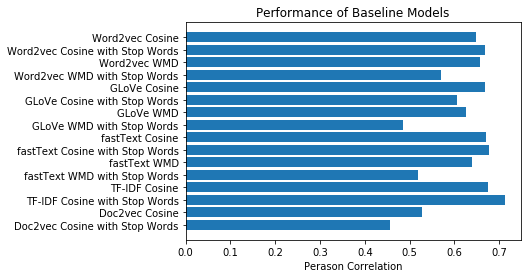

In [40]:
fig, ax = plt.subplots()

# Example data
x = list(baselines.keys())
x_pos = np.arange(len(x))
y = list(results.values())

ax.barh(x_pos, y, align='center')
ax.set_yticks(x_pos)
ax.set_yticklabels(x)
ax.invert_yaxis() 
ax.set_xlabel('Perason Correlation')
ax.set_title('Performance of Baseline Models')

plt.show()

In [41]:
# Clean up data
tmp_dir.cleanup()

In [42]:
# Record results with scrapbook for tests
sb.glue("results", results)